# Positional Embeddings: Building Intuition from First Principles

The standard sinusoidal positional embedding formula looks like this:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

**This is confusing.** Why sine and cosine? Why 10000? Why alternate? Why different frequencies?

This notebook will build up to this formula so that by the end, each design choice feels almost *obvious*. We'll start from the fundamental problem and discover each piece through experimentation.


In [286]:
import sys
from pathlib import Path

# Add workspace root to Python path so we can import silen_lib
workspace_root = Path.cwd().parent.parent
if str(workspace_root) not in sys.path:
    sys.path.insert(0, str(workspace_root))

import silen_lib.utils as utils

import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'


## The Problem

A transformer's self-attention treats the input as a **set**, not a sequence. Unlike RNNs, transformers don't have any built-in notion of position (there's no recurrence).

Without positional information:

- "The cat sat on the mat" 
- "The mat sat on the cat"

...would produce **identical** attention patterns. The transformer has no idea which token came first.


In [287]:
# Toy example: three "tokens" with random embeddings
tokens = np.array([
    [0.5, 0.8],   # token A
    [0.2, 0.9],   # token B  
    [0.7, 0.3],   # token C
])

# Simple attention: how much does each token attend to each other?
# (just dot products, ignoring scaling)
attention = tokens @ tokens.T
print("Attention matrix (no position info):")
print(attention.round(2))


Attention matrix (no position info):
[[0.89 0.82 0.59]
 [0.82 0.85 0.41]
 [0.59 0.41 0.58]]


In [288]:
# Shuffle the order: C, A, B instead of A, B, C
tokens_shuffled = tokens[[2, 0, 1]]

attention_shuffled = tokens_shuffled @ tokens_shuffled.T
print("Attention after shuffling (C, A, B):")
print(attention_shuffled.round(2))


Attention after shuffling (C, A, B):
[[0.58 0.59 0.41]
 [0.59 0.89 0.82]
 [0.41 0.82 0.85]]


The model can't tell these orderings apart! In other words, the model is equivariant to the order of the tokens.

## Goal: Encode Position

One way that we can do this, is to push the embeddings into a high-dimensional space where each dimension corresponds to a different position.

So all tokens that are the same distance apart in the sequence, are pushed together in the embedding space. And with this, the model can learn to attend to tokens based on their position.

Let's try this out!

## First Attempt

The simplest idea: just use integers as position. Position 0, 1, 2, 3...


In [289]:
utils.set_seed(33)
example_tensor = torch.randn(3, 6)
print("Example tensor shape:", example_tensor.shape)
print("Example tensor:", example_tensor)

# these represent three embeddings of tokens 
# for example for seed 42
# "The": [ 1.9269,  1.4873, -0.4974,  0.4396, -0.7581,  1.0783]
# "cat": [ 0.8008,  1.6806,  0.3559, -0.6866,  0.6105,  1.3347]
# "sat":  [-0.2316,  0.0418, -0.2516,  0.8599, -0.3097, -0.3957]

Example tensor shape: torch.Size([3, 6])
Example tensor: tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [-0.5728,  0.5368, -0.8906,  0.9865, -0.3192,  0.3207],
        [-0.1966, -0.7767, -1.4657, -1.0870,  0.3473,  0.9572]])


In [290]:
positions = np.arange(example_tensor.shape[0])
print("Position values:", positions)

# Add positions to the example_tensor (broadcasting over columns)
modified_tensor = example_tensor + positions[:, None]
print("Modified example tensor (after adding positions):", modified_tensor)


Position values: [0 1 2]
Modified example tensor (after adding positions): tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [ 0.4272,  1.5368,  0.1094,  1.9865,  0.6808,  1.3207],
        [ 1.8034,  1.2233,  0.5343,  0.9130,  2.3473,  2.9572]],
       dtype=torch.float64)


In [291]:
# Problem 1: Scale explodes with sequence length

# We'll make a large fake embedding tensor: 1000 tokens, each with embedding dim 4
large_tensor = torch.randn(1000, 6)
positions = np.arange(large_tensor.shape[0])

# Add positions to the embeddings (broadcasts over columns)
modified_large_tensor = large_tensor + positions[:, None]

print("Original last 3 embeddings:\n", large_tensor[-3:])
print("Positions of last 3 tokens:", positions[-3:])
print("Modified (with position) last 3 embeddings:\n", modified_large_tensor[-3:])

# See how large these values get!


Original last 3 embeddings:
 tensor([[ 0.7608, -0.1367,  0.9880, -0.4994, -0.0466, -1.3236],
        [ 0.7420,  1.3876,  0.6875,  2.4508, -1.0924,  0.1551],
        [ 0.2145,  0.7141,  0.2667, -2.3133, -0.4357, -0.8918]])
Positions of last 3 tokens: [997 998 999]
Modified (with position) last 3 embeddings:
 tensor([[ 997.7608,  996.8633,  997.9880,  996.5006,  996.9534,  995.6764],
        [ 998.7420,  999.3876,  998.6875, 1000.4508,  996.9076,  998.1551],
        [ 999.2145,  999.7141,  999.2667,  996.6867,  998.5643,  998.1082]],
       dtype=torch.float64)


**Problem**: Token embeddings are typically small values (around -1 to 1). If we add position 9999 directly, the position signal completely drowns out the token meaning (aka semantics).

What if we normalize?


In [292]:
# Attempt 2: Normalize positions to [0, 1] instead of adding large absolute values directly
def normalized_position(pos, max_len):
    return pos / max_len

# This fixes the scale explosion problem, but creates a new problem...
# Let's say our "cat" token appears at position 2 in different length sequences

print("What encoding does 'cat' at position 2 get?")
print()

# In a short sequence (length 6)
seq_len_short = 6
pos_2_short = normalized_position(2, seq_len_short)
print(f"Sequence length 6:  position 2 → {pos_2_short:.3f}")

# In our 3-token sequence
seq_len_medium = 3
pos_2_medium = normalized_position(2, seq_len_medium)
print(f"Sequence length 3:  position 2 → {pos_2_medium:.3f}")

# In a longer sequence (length 100)
seq_len_long = 100
pos_2_long = normalized_position(2, seq_len_long)
print(f"Sequence length 100: position 2 → {pos_2_long:.3f}")

print("\n⚠️ Problem: Position 2 gets DIFFERENT encodings depending on sequence length!")
print("The model can't learn what 'position 2' means - it keeps changing!")
print("\nThis is called SCALE VARIANCE - the encoding depends on the scale (length) of the sequence.")


What encoding does 'cat' at position 2 get?

Sequence length 6:  position 2 → 0.333
Sequence length 3:  position 2 → 0.667
Sequence length 100: position 2 → 0.020

⚠️ Problem: Position 2 gets DIFFERENT encodings depending on sequence length!
The model can't learn what 'position 2' means - it keeps changing!

This is called SCALE VARIANCE - the encoding depends on the scale (length) of the sequence.


### Issues with integer positions:

(a) Scaling creates a dilemma: If we scale positions down to keep values small (e.g., divide by a constant), we get tiny differences at the start of sequences that barely encode position. If we don't scale enough, values blow up for long sequences and drown out the token semantics. We saw this in the first attempt.

(b) Normalization causes scale variance: Normalizing by sequence length (pos/max_len) makes position 5 mean something different in a 10-token sequence (0.5) versus a 100-token sequence (0.05). The model can't learn what "position 5" means because it keeps changing based on sequence length. We saw this in the second attempt.

(c) Raw integers don't generalize: If you train on sequences up to length 100, then try position 150, the model has never seen that value before. It can't extrapolate to unseen position magnitudes.

## What Do We Actually Need?

Let's think about what a good positional encoding needs:

1. **Bounded values** — shouldn't explode for long sequences
2. **Unique per position** — each position needs a distinct encoding
3. **Consistent meaning** — position 5 should mean the same thing regardless of sequence length  
4. **Smooth** — nearby positions should have similar encodings (position 5 and 6 are related)
5. **Learnable relationships** — the model should be able to figure out "token A is 3 positions before token B"

What function is bounded, smooth, and produces unique values? 🤔


## Enter the Sine Function

Sine is bounded between -1 and 1, smooth, and periodic. Let's try using `sin(position)` as our positional encoding!


In [293]:
# Let's use sin(position) to encode position in our embeddings
# Recall our example: "The" (pos 0), "cat" (pos 1), "sat" (pos 2)

positions = np.arange(example_tensor.shape[0])
sin_encoding = np.sin(positions)

print("Position → sin(position):")
for pos, enc in zip(positions, sin_encoding):
    print(f"  Position {pos}: sin({pos}) = {enc:.4f}")

# Add to our example tensor
modified_tensor = example_tensor + sin_encoding[:, None]
print("\nOriginal embeddings:")
print(example_tensor)
print("\nAfter adding sin(position):")
print(modified_tensor)


Position → sin(position):
  Position 0: sin(0) = 0.0000
  Position 1: sin(1) = 0.8415
  Position 2: sin(2) = 0.9093

Original embeddings:
tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [-0.5728,  0.5368, -0.8906,  0.9865, -0.3192,  0.3207],
        [-0.1966, -0.7767, -1.4657, -1.0870,  0.3473,  0.9572]])

After adding sin(position):
tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [ 0.2687,  1.3782, -0.0491,  1.8279,  0.5223,  1.1621],
        [ 0.7127,  0.1326, -0.5564, -0.1777,  1.2566,  1.8665]],
       dtype=torch.float64)


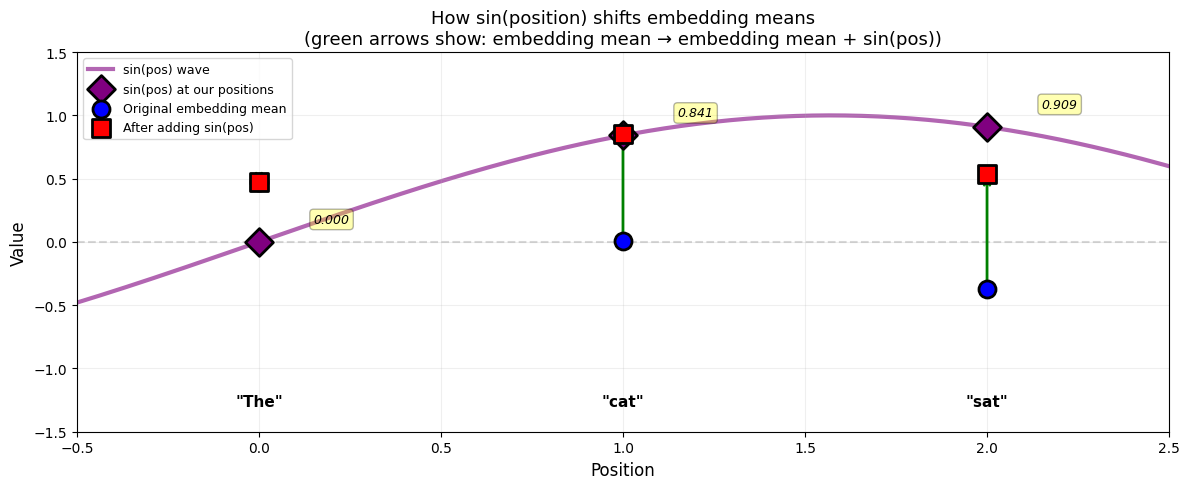

Notice: Each embedding is shifted by exactly sin(position)
The purple wave shows sin(x), and we sample it at positions 0, 1, 2


In [294]:
# Visualize how sin(position) shifts our embeddings
fig, ax = plt.subplots(figsize=(12, 5))

positions = np.arange(3)
sin_values = np.sin(positions)

# Plot the continuous sin wave prominently
x_smooth = np.linspace(-0.5, 2.5, 200)
ax.plot(x_smooth, np.sin(x_smooth), 'purple', linewidth=3, label='sin(pos) wave', alpha=0.6, zorder=1)

# Mark the discrete sin values at our positions
ax.scatter(positions, sin_values, s=200, marker='D', color='purple', 
           label='sin(pos) at our positions', zorder=4, edgecolors='black', linewidths=2)

# Compute mean of embeddings (represents the "center" of each embedding vector)
original_means = example_tensor.numpy().mean(axis=1)
modified_means = modified_tensor.numpy().mean(axis=1)

# Plot original embedding means
ax.scatter(positions, original_means, s=150, marker='o', color='blue', 
           label='Original embedding mean', zorder=5, edgecolors='black', linewidths=2)

# Plot modified embedding means
ax.scatter(positions, modified_means, s=150, marker='s', color='red', 
           label='After adding sin(pos)', zorder=5, edgecolors='black', linewidths=2)

# Draw arrows showing the shift
for pos in positions:
    ax.annotate('', xy=(pos, modified_means[pos]), xytext=(pos, original_means[pos]),
                arrowprops=dict(arrowstyle='->', lw=2, color='green'))
    # Add sin value text
    ax.text(pos + 0.15, sin_values[pos] + 0.15, f'{sin_values[pos]:.3f}', 
            fontsize=9, style='italic', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Mark our tokens
tokens = ["The", "cat", "sat"]
for pos, token in enumerate(tokens):
    ax.text(pos, -1.3, f'"{token}"', fontsize=11, ha='center', weight='bold')

ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('How sin(position) shifts embedding means\n(green arrows show: embedding mean → embedding mean + sin(pos))', fontsize=13)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-1.5, 1.5)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print("Notice: Each embedding is shifted by exactly sin(position)")
print("The purple wave shows sin(x), and we sample it at positions 0, 1, 2")

In [295]:
# Problem: sin repeats every 2π ≈ 6.28 positions!
# Let's see what happens with a longer sequence

positions_long = np.arange(20)
sin_values = np.sin(positions_long)

print("Position → sin(position):")
for pos, val in zip(positions_long, sin_values):
    print(f"  Position {pos}: sin({pos}) = {val:+.4f}")
    
print(f"\n⚠️ Notice: sin(8) = {np.sin(8):.4f} and sin(14) = {np.sin(14):.4f}")
print(f"   They're almost the same! (difference: {abs(np.sin(8) - np.sin(14)):.4f})")


Position → sin(position):
  Position 0: sin(0) = +0.0000
  Position 1: sin(1) = +0.8415
  Position 2: sin(2) = +0.9093
  Position 3: sin(3) = +0.1411
  Position 4: sin(4) = -0.7568
  Position 5: sin(5) = -0.9589
  Position 6: sin(6) = -0.2794
  Position 7: sin(7) = +0.6570
  Position 8: sin(8) = +0.9894
  Position 9: sin(9) = +0.4121
  Position 10: sin(10) = -0.5440
  Position 11: sin(11) = -1.0000
  Position 12: sin(12) = -0.5366
  Position 13: sin(13) = +0.4202
  Position 14: sin(14) = +0.9906
  Position 15: sin(15) = +0.6503
  Position 16: sin(16) = -0.2879
  Position 17: sin(17) = -0.9614
  Position 18: sin(18) = -0.7510
  Position 19: sin(19) = +0.1499

⚠️ Notice: sin(8) = 0.9894 and sin(14) = 0.9906
   They're almost the same! (difference: 0.0012)


**The Problem**: Since sine is periodic, many positions get nearly identical encodings! If we have a 7+ token sequence, the model can't distinguish between the 1st and 7th tokens for example because sine has a fixed period of 2π ≈ 6.28. And as shown above, it gets even worse for longer sequences.

We need a way to control this.

## Adjusting the sine wave

We can stretch or compress the sine wave by multiplying position by a frequency term ω (omega):

$$\sin(\omega \cdot pos)$$

- Higher ω = faster oscillation (repeats more quickly)
- Lower ω = slower oscillation (takes longer to repeat)


In [296]:
# Let's try a lower frequency: ω = 0.1
# This means sin(0.1 * position) - the wave stretches out

freq_low = 0.1
positions = np.arange(15)

print(f"With ω = {freq_low}:")
print("Position → sin(ω × position):")
for pos in positions:
    val = np.sin(freq_low * pos)
    print(f"  Position {pos}: sin({freq_low} × {pos}) = sin({freq_low * pos:.1f}) = {val:+.4f}")

print(f"\n✓ Now position 8 and position 14 are different!")
print(f"  sin(0.1 × 8) = {np.sin(freq_low * 8):.4f}")
print(f"  sin(0.1 × 14) = {np.sin(freq_low * 14):.4f}")


With ω = 0.1:
Position → sin(ω × position):
  Position 0: sin(0.1 × 0) = sin(0.0) = +0.0000
  Position 1: sin(0.1 × 1) = sin(0.1) = +0.0998
  Position 2: sin(0.1 × 2) = sin(0.2) = +0.1987
  Position 3: sin(0.1 × 3) = sin(0.3) = +0.2955
  Position 4: sin(0.1 × 4) = sin(0.4) = +0.3894
  Position 5: sin(0.1 × 5) = sin(0.5) = +0.4794
  Position 6: sin(0.1 × 6) = sin(0.6) = +0.5646
  Position 7: sin(0.1 × 7) = sin(0.7) = +0.6442
  Position 8: sin(0.1 × 8) = sin(0.8) = +0.7174
  Position 9: sin(0.1 × 9) = sin(0.9) = +0.7833
  Position 10: sin(0.1 × 10) = sin(1.0) = +0.8415
  Position 11: sin(0.1 × 11) = sin(1.1) = +0.8912
  Position 12: sin(0.1 × 12) = sin(1.2) = +0.9320
  Position 13: sin(0.1 × 13) = sin(1.3) = +0.9636
  Position 14: sin(0.1 × 14) = sin(1.4) = +0.9854

✓ Now position 8 and position 14 are different!
  sin(0.1 × 8) = 0.7174
  sin(0.1 × 14) = 0.9854


In [297]:
# But wait - there's a tradeoff!
# With low frequency, NEARBY positions become hard to distinguish

freq_high = 1.0
freq_low = 0.1

print("THE TRADEOFF:")
print("\nHigh frequency (ω=1.0) - good for nearby, bad for far:")
print(f"  Position 0 vs 1: |{np.sin(freq_high * 0):.4f} - {np.sin(freq_high * 1):.4f}| = {abs(np.sin(freq_high * 0) - np.sin(freq_high * 1)):.4f} ✓ different")
print(f"  Position 0 vs 6: |{np.sin(freq_high * 0):.4f} - {np.sin(freq_high * 6):.4f}| = {abs(np.sin(freq_high * 0) - np.sin(freq_high * 6)):.4f} ✗ too similar!")

print("\nLow frequency (ω=0.1) - good for far, bad for nearby:")
print(f"  Position 0 vs 1: |{np.sin(freq_low * 0):.4f} - {np.sin(freq_low * 1):.4f}| = {abs(np.sin(freq_low * 0) - np.sin(freq_low * 1)):.4f} ✗ too similar!")
print(f"  Position 0 vs 6: |{np.sin(freq_low * 0):.4f} - {np.sin(freq_low * 6):.4f}| = {abs(np.sin(freq_low * 0) - np.sin(freq_low * 6)):.4f} ✓ different")

print("\n→ We can't win with a single frequency!")


THE TRADEOFF:

High frequency (ω=1.0) - good for nearby, bad for far:
  Position 0 vs 1: |0.0000 - 0.8415| = 0.8415 ✓ different
  Position 0 vs 6: |0.0000 - -0.2794| = 0.2794 ✗ too similar!

Low frequency (ω=0.1) - good for far, bad for nearby:
  Position 0 vs 1: |0.0000 - 0.0998| = 0.0998 ✗ too similar!
  Position 0 vs 6: |0.0000 - 0.5646| = 0.5646 ✓ different

→ We can't win with a single frequency!


## The Key Insight Multiple Dimensions

What if instead of using a single frequency number for the position encoding that we broadcast to all weights in the embedding matrix, we use multiple dimensions to encode what it means to be in a certain position?

**Solution**: Use MULTIPLE dimensions, each with a DIFFERENT frequency!

- High frequency dimension → distinguishes nearby positions  
- Low frequency dimension → distinguishes far positions

Together, they give us the best of both worlds.

In [298]:
# Let's encode each position with TWO dimensions: one high freq, one low freq
freq_high = 1.0
freq_low = 0.1

print("Two-dimensional encoding for positions 0-20:")
print("pos | sin(1.0×pos) | sin(0.1×pos)")
print("-" * 40)
for pos in range(21):
    high = np.sin(freq_high * pos)
    low = np.sin(freq_low * pos)
    print(f"  {pos} |    {high:+.4f}   |    {low:+.4f}")

print("\nNow position 8 and 14 are distinguishable!")
print(f"  pos 8:  ({np.sin(freq_high * 8):+.4f}, {np.sin(freq_low * 8):+.4f})")
print(f"  pos 14: ({np.sin(freq_high * 14):+.4f}, {np.sin(freq_low * 14):+.4f})")


Two-dimensional encoding for positions 0-20:
pos | sin(1.0×pos) | sin(0.1×pos)
----------------------------------------
  0 |    +0.0000   |    +0.0000
  1 |    +0.8415   |    +0.0998
  2 |    +0.9093   |    +0.1987
  3 |    +0.1411   |    +0.2955
  4 |    -0.7568   |    +0.3894
  5 |    -0.9589   |    +0.4794
  6 |    -0.2794   |    +0.5646
  7 |    +0.6570   |    +0.6442
  8 |    +0.9894   |    +0.7174
  9 |    +0.4121   |    +0.7833
  10 |    -0.5440   |    +0.8415
  11 |    -1.0000   |    +0.8912
  12 |    -0.5366   |    +0.9320
  13 |    +0.4202   |    +0.9636
  14 |    +0.9906   |    +0.9854
  15 |    +0.6503   |    +0.9975
  16 |    -0.2879   |    +0.9996
  17 |    -0.9614   |    +0.9917
  18 |    -0.7510   |    +0.9738
  19 |    +0.1499   |    +0.9463
  20 |    +0.9129   |    +0.9093

Now position 8 and 14 are distinguishable!
  pos 8:  (+0.9894, +0.7174)
  pos 14: (+0.9906, +0.9854)


In [299]:
# Let's apply this to our actual embeddings
# Our example_tensor has 5 dimensions, so let's use 2 frequencies (4 dims for sin/cos pairs + 1 extra)

frequencies = [1.0, 0.1]  # high and low frequency

# For our 3 tokens: "The" (pos 0), "cat" (pos 1), "sat" (pos 2)
print("Multi-frequency positional encoding for our 3 tokens:")
print("Token   | pos | high freq   | low freq")
print("-" * 50)

tokens = ["The", "cat", "sat"]
for pos, token in enumerate(tokens):
    high = np.sin(frequencies[0] * pos)
    low = np.sin(frequencies[1] * pos)
    print(f"{token:7} |  {pos}  | sin({frequencies[0]}×{pos})={high:+.3f} | sin({frequencies[1]}×{pos})={low:+.3f}")


Multi-frequency positional encoding for our 3 tokens:
Token   | pos | high freq   | low freq
--------------------------------------------------
The     |  0  | sin(1.0×0)=+0.000 | sin(0.1×0)=+0.000
cat     |  1  | sin(1.0×1)=+0.841 | sin(0.1×1)=+0.100
sat     |  2  | sin(1.0×2)=+0.909 | sin(0.1×2)=+0.199


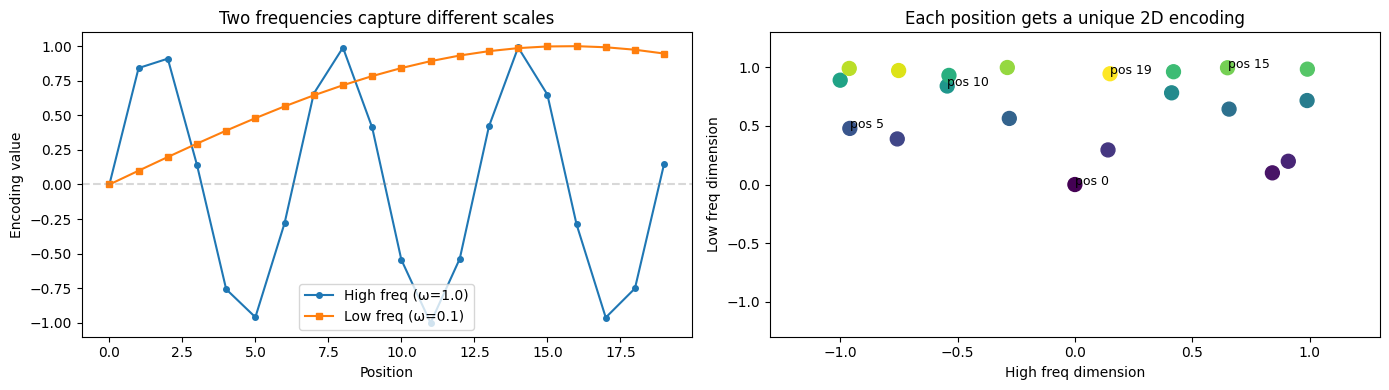

In [300]:
# Visualize the two-frequency encoding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

positions = np.arange(20)

# Left: show both frequencies over position
ax1.plot(positions, np.sin(1.0 * positions), 'o-', label='High freq (ω=1.0)', markersize=4)
ax1.plot(positions, np.sin(0.1 * positions), 's-', label='Low freq (ω=0.1)', markersize=4)
ax1.set_xlabel('Position')
ax1.set_ylabel('Encoding value')
ax1.set_title('Two frequencies capture different scales')
ax1.legend()
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

# Right: show as 2D points
ax2.scatter([np.sin(1.0 * p) for p in positions], 
           [np.sin(0.1 * p) for p in positions], 
           c=positions, cmap='viridis', s=100)
for p in [0, 5, 10, 15, 19]:
    ax2.annotate(f'pos {p}', (np.sin(1.0 * p), np.sin(0.1 * p)), 
                fontsize=9, ha='left')
ax2.set_xlabel('High freq dimension')
ax2.set_ylabel('Low freq dimension')
ax2.set_title('Each position gets a unique 2D encoding')
ax2.set_xlim(-1.3, 1.3)
ax2.set_ylim(-1.3, 1.3)

plt.tight_layout()
plt.show()


This is great and solves most of our problems! 

But we can do better. 

There's a way we can make position encodings that are even more unique and learnable while maintaining the same properties of this sine wave.

## Solution: Add Cosine

There's another trick: for each frequency, we can use **both sine and cosine**

The problem is that sine alone can still be ambiguous. And at times we can still have similar values for different positions.

**Solution**: Add cosine! Since cosine is phase-shifted by π/2 from sine, when two positions have the same sine value, they'll have DIFFERENT cosine values.

Cosine is just sine shifted by π/2 (90°). Using both gives us two orthogonal (independent) signals at each frequency.


In [301]:
freq = 1.0

print("Adding cosine resolves the ambiguity!\n")
print("pos | sin(pos) | cos(pos) | (sin, cos) pair")
print("-" * 50)

ambiguous_positions = [0, 6, 8, 14]
for pos in ambiguous_positions:
    s = np.sin(freq * pos)
    c = np.cos(freq * pos)
    print(f" {pos:2} |  {s:+.4f}  |  {c:+.4f}  | ({s:+.4f}, {c:+.4f})")

print("\n✓ Cosine adds further uniqueness!")


Adding cosine resolves the ambiguity!

pos | sin(pos) | cos(pos) | (sin, cos) pair
--------------------------------------------------
  0 |  +0.0000  |  +1.0000  | (+0.0000, +1.0000)
  6 |  -0.2794  |  +0.9602  | (-0.2794, +0.9602)
  8 |  +0.9894  |  -0.1455  | (+0.9894, -0.1455)
 14 |  +0.9906  |  +0.1367  | (+0.9906, +0.1367)

✓ Cosine adds further uniqueness!


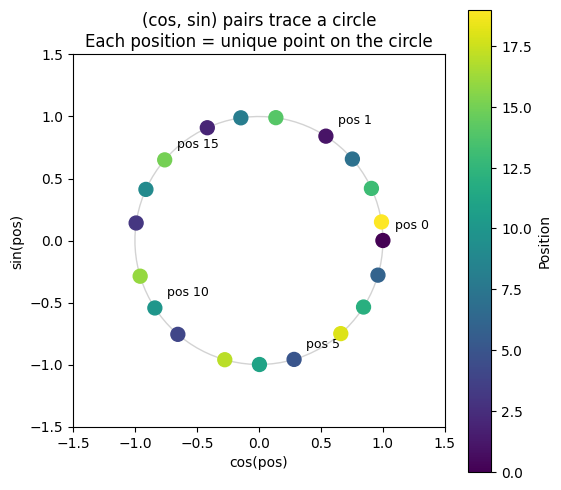

In [302]:
# Visualize: (sin, cos) traces out a circle as position increases
fig, ax = plt.subplots(figsize=(6, 6))

positions = np.arange(20)
sin_vals = np.sin(positions)
cos_vals = np.cos(positions)

# Draw the unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'lightgray', linewidth=1)

# Plot position points
scatter = ax.scatter(cos_vals, sin_vals, c=positions, cmap='viridis', s=100, zorder=5)
for pos in [0, 1, 5, 10, 15]:
    ax.annotate(f'pos {pos}', (cos_vals[pos]+0.1, sin_vals[pos]+0.1), fontsize=9)

ax.set_xlabel('cos(pos)')
ax.set_ylabel('sin(pos)')
ax.set_title('(cos, sin) pairs trace a circle\nEach position = unique point on the circle')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
plt.colorbar(scatter, label='Position')
plt.show()


Positional encodings (2 frequencies × 2 for sin/cos = 4 dimensions):
[[ 0.     1.     0.     1.   ]
 [ 0.841  0.54   0.1    0.995]
 [ 0.909 -0.416  0.199  0.98 ]]


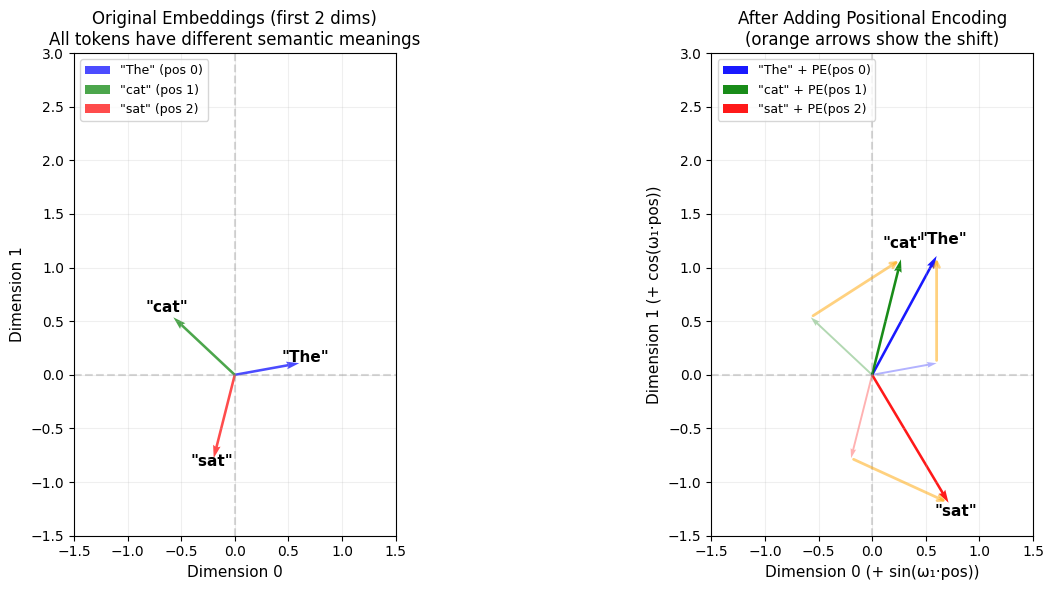

In [303]:
# Visualize how (sin, cos) positional encoding shifts our embeddings
# We'll use 2 frequencies, giving us 4 dimensions of positional info

# Create a simple 2-frequency positional encoding for our 3 tokens
frequencies = [1.0, 0.1]
pe_2freq = np.zeros((3, 4))

for pos in range(3):
    for i, freq in enumerate(frequencies):
        pe_2freq[pos, 2*i] = np.sin(freq * pos)  # sin
        pe_2freq[pos, 2*i+1] = np.cos(freq * pos)  # cos

print("Positional encodings (2 frequencies × 2 for sin/cos = 4 dimensions):")
print(pe_2freq.round(3))

# Add positional encoding to first 4 dimensions of our embeddings
original_vecs = example_tensor.numpy()[:, :2]  
modified_vecs = original_vecs + pe_2freq[:, :2]
# for the purpose of visualization, we only use the first 2 dimensions

# Plot as 2D vectors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

tokens = ["The", "cat", "sat"]
colors = ['blue', 'green', 'red']

# Left plot: Original embeddings (first 2 dimensions)
for i, (token, color) in enumerate(zip(tokens, colors)):
    ax1.quiver(0, 0, original_vecs[i, 0], original_vecs[i, 1], 
               angles='xy', scale_units='xy', scale=1, color=color, 
               width=0.008, alpha=0.7, label=f'"{token}" (pos {i})')
    ax1.text(original_vecs[i, 0]*1.1, original_vecs[i, 1]*1.1, f'"{token}"', 
             fontsize=11, weight='bold', ha='center')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 3)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax1.set_xlabel('Dimension 0', fontsize=11)
ax1.set_ylabel('Dimension 1', fontsize=11)
ax1.set_title('Original Embeddings (first 2 dims)\nAll tokens have different semantic meanings', fontsize=12)
ax1.grid(True, alpha=0.2)
ax1.set_aspect('equal')
ax1.legend(loc='upper left', fontsize=9)

# Right plot: After adding positional encoding
for i, (token, color) in enumerate(zip(tokens, colors)):
    # Show both original and modified
    ax2.quiver(0, 0, original_vecs[i, 0], original_vecs[i, 1], 
               angles='xy', scale_units='xy', scale=1, color=color, 
               width=0.006, alpha=0.3, linestyle='dashed')
    ax2.quiver(0, 0, modified_vecs[i, 0], modified_vecs[i, 1], 
               angles='xy', scale_units='xy', scale=1, color=color, 
               width=0.008, alpha=0.9, label=f'"{token}" + PE(pos {i})')
    
    # Arrow showing the shift
    ax2.annotate('', xy=(modified_vecs[i, 0], modified_vecs[i, 1]), 
                 xytext=(original_vecs[i, 0], original_vecs[i, 1]),
                 arrowprops=dict(arrowstyle='->', lw=2, color='orange', alpha=0.5))
    
    ax2.text(modified_vecs[i, 0]*1.1, modified_vecs[i, 1]*1.1, f'"{token}"', 
             fontsize=11, weight='bold', ha='center')

ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 3)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax2.set_xlabel('Dimension 0 (+ sin(ω₁·pos))', fontsize=11)
ax2.set_ylabel('Dimension 1 (+ cos(ω₁·pos))', fontsize=11)
ax2.set_title('After Adding Positional Encoding\n(orange arrows show the shift)', fontsize=12)
ax2.grid(True, alpha=0.2)
ax2.set_aspect('equal')
ax2.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

## The Frequency Formula — Where Does 10000 Come From?

So far we've picked frequencies like 1.0 and 0.1 arbitrarily. The original Transformer paper uses a specific formula:

$$\omega_i = \frac{1}{10000^{2i/d}}$$

where:
- `i` = which frequency we're computing (0, 1, 2, ...) which is related to the position in embedding matrix to encode more uniqueness per dimension. For both cos and sin, the frequency is the same for each pair. So dimensions 0 and 1 have the same frequency but are sin and cos respectively. Etc.
- `d` = total embedding dimension

Let's see what frequencies this gives us.


In [304]:
# Let's compute frequencies for a small embedding dimension
d = 10  # embedding dimension (our example_tensor has d=5, but 6 is easier to demonstrate)

print(f"For d={d}, we have {d//2} frequency pairs (sin/cos):\n")
print("-" * 60)
print("x | i: {2*i},{2*i+1} |   2i/d   |    10000^(2i/d)   | ω = 1/10000^(2i/d) | sin, cos(ω*x)")
print(f"pos |  i: dims  |     exponent     |  base power  |      freq      |    sin,cos(freq*pos)")
for x in range(2): # the 2 vectors
    for i in range(d // 2): # dimensions of the vector
        exponent = 2 * i / d
        base_power = 10000 ** exponent
        freq = 1 / base_power
        pos_freq = x * freq
        cos_pos_freq = np.cos(pos_freq)
        sin_pos_freq = np.sin(pos_freq)
        print(f"{x}   |   {i}: {2*i},{2*i+1} |       {exponent:.3f}      |   {base_power:>10.2f} |     {freq:.6f}    |    {sin_pos_freq}, {cos_pos_freq:.6f}")


For d=10, we have 5 frequency pairs (sin/cos):

------------------------------------------------------------
x | i: {2*i},{2*i+1} |   2i/d   |    10000^(2i/d)   | ω = 1/10000^(2i/d) | sin, cos(ω*x)
pos |  i: dims  |     exponent     |  base power  |      freq      |    sin,cos(freq*pos)
0   |   0: 0,1 |       0.000      |         1.00 |     1.000000    |    0.0, 1.000000
0   |   1: 2,3 |       0.200      |         6.31 |     0.158489    |    0.0, 1.000000
0   |   2: 4,5 |       0.400      |        39.81 |     0.025119    |    0.0, 1.000000
0   |   3: 6,7 |       0.600      |       251.19 |     0.003981    |    0.0, 1.000000
0   |   4: 8,9 |       0.800      |      1584.89 |     0.000631    |    0.0, 1.000000
1   |   0: 0,1 |       0.000      |         1.00 |     1.000000    |    0.8414709848078965, 0.540302
1   |   1: 2,3 |       0.200      |         6.31 |     0.158489    |    0.1578266401303058, 0.987467
1   |   2: 4,5 |       0.400      |        39.81 |     0.025119    |    0.025116

**Key insight**: The frequencies form a geometric progression:
- i=0 gives ω=1 (high frequency, repeats every ~6 positions)  
- i=d/2-1 gives ω≈1/10000 (very low frequency, wavelength ~63,000 positions)

**Why 10000?** It ensures we can handle sequences up to ~10,000 tokens without the lowest frequency repeating. This is why it's called a "base" — it sets the maximum context length.


### Understanding the Low Frequency Dimensions

Notice in the encoding above: the last few dimensions (low frequency) barely change between positions 0, 1, and 2. This is the tradeoff we discussed earlier — but now we have high frequency dimensions to compensate!


In [305]:
# Show explicitly: high freq dimensions change a lot, low freq barely changes
d = 8
i_values = np.arange(d // 2)
frequencies = 1 / (10000 ** (2 * i_values / d))

print("Change in encoding from position 0 → position 1:")
print()
for i, freq in enumerate(frequencies):
    diff_sin = abs(np.sin(freq * 1) - np.sin(freq * 0))
    diff_cos = abs(np.cos(freq * 1) - np.cos(freq * 0))
    print(f"Frequency {i} (ω={freq:.6f}): sin Δ = {diff_sin:.6f}, cos Δ = {diff_cos:.6f}")
    
print("\n→ High frequencies (top) capture fine position differences")
print("→ Low frequencies (bottom) capture coarse/global position")


Change in encoding from position 0 → position 1:

Frequency 0 (ω=1.000000): sin Δ = 0.841471, cos Δ = 0.459698
Frequency 1 (ω=0.100000): sin Δ = 0.099833, cos Δ = 0.004996
Frequency 2 (ω=0.010000): sin Δ = 0.010000, cos Δ = 0.000050
Frequency 3 (ω=0.001000): sin Δ = 0.001000, cos Δ = 0.000000

→ High frequencies (top) capture fine position differences
→ Low frequencies (bottom) capture coarse/global position


## Putting It All Together

Now we have all the pieces. The full formula:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

Let's build a function that computes this and apply it to our example.


In [306]:
def positional_encoding(max_len, d_model):
    """
    Generate sinusoidal positional encodings.
    
    Args:
        max_len: maximum sequence length
        d_model: embedding dimension (must be even)
    
    Returns:
        (max_len, d_model) array of positional encodings
    """
    positions = np.arange(max_len)[:, np.newaxis]  # (max_len, 1)
    i = np.arange(d_model // 2)[np.newaxis, :]     # (1, d_model/2)
    
    # Frequency for each dimension: 1 / 10000^(2i/d)
    frequencies = 1 / (10000 ** (2 * i / d_model))
    
    # Compute angles: position × frequency
    angles = positions * frequencies  # (max_len, d_model/2)
    
    # Interleave sin and cos: [sin0, cos0, sin1, cos1, ...]
    pe = np.zeros((max_len, d_model))
    pe[:, 0::2] = np.sin(angles)  # even indices
    pe[:, 1::2] = np.cos(angles)  # odd indices
    
    return pe


In [308]:
# Now let's add this to actual token embeddings!
# We'll use a tensor with d=6 to match our positional encoding
print("Original token embeddings:")
token_embeddings = example_tensor
print(token_embeddings)

print("\nPositional encodings (what we add):")
print(pe)

# Add them together
combined = example_tensor.numpy() + pe
print("\nToken embeddings + positional encoding:")
print(combined.round(4))


Original token embeddings:
tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [-0.5728,  0.5368, -0.8906,  0.9865, -0.3192,  0.3207],
        [-0.1966, -0.7767, -1.4657, -1.0870,  0.3473,  0.9572]])

Positional encodings (what we add):
[[ 0.          1.          0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.04639922  0.99892298  0.00215443  0.99999768]
 [ 0.90929743 -0.41614684  0.0926985   0.99569422  0.00430886  0.99999072]]

Token embeddings + positional encoding:
[[ 0.6014  1.1087  1.253   0.3098  0.2395  2.3365]
 [ 0.2687  1.0771 -0.8442  1.9854 -0.317   1.3207]
 [ 0.7127 -1.1929 -1.373  -0.0913  0.3516  1.9572]]


In [309]:
# Key point: same token at different positions now has different representations!
# If we had "The" at position 0 vs position 5:

pe_long = positional_encoding(max_len=10, d_model=6)

the_embedding = token_embeddings[0].numpy()  # "The" token embedding

the_at_pos_0 = the_embedding + pe_long[0]
the_at_pos_5 = the_embedding + pe_long[5]

print('"The" at position 0:', the_at_pos_0.round(4))
print('"The" at position 5:', the_at_pos_5.round(4))
print('\nDifference:', (the_at_pos_5 - the_at_pos_0).round(4))
print("→ Same token, but model sees different vectors based on position!")


"The" at position 0: [0.6014 1.1087 1.253  0.3098 0.2395 2.3365]
"The" at position 5: [-0.3576  0.3924  1.483   0.283   0.2503  2.3365]

Difference: [-9.589e-01 -7.163e-01  2.300e-01 -2.680e-02  1.080e-02 -1.000e-04]
→ Same token, but model sees different vectors based on position!


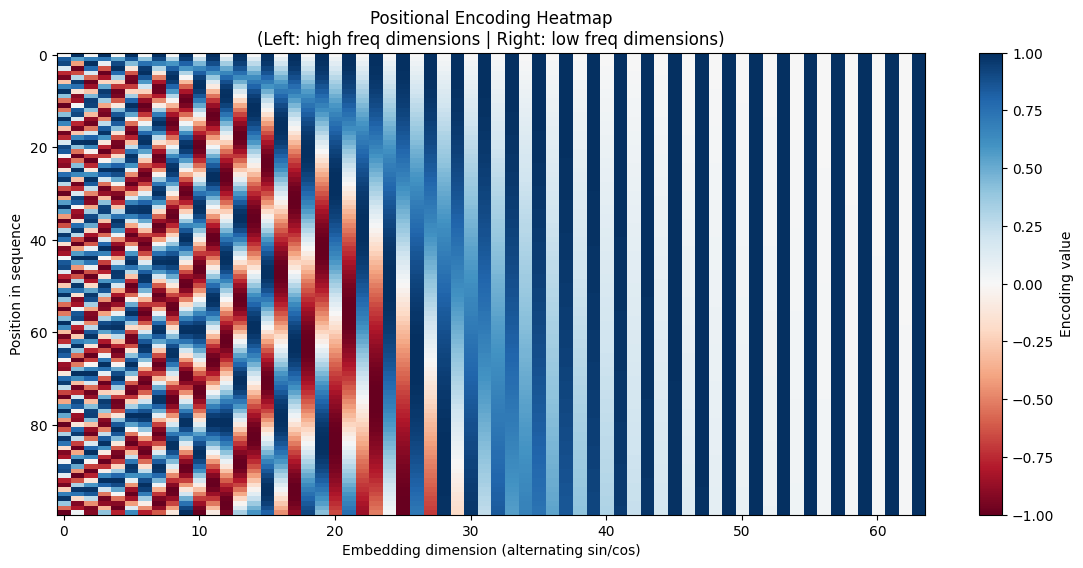

Shape: (100, 64) (100 positions × 64 dimensions)


In [310]:
# Visualize the full positional encoding matrix for a longer sequence
pe_vis = positional_encoding(max_len=100, d_model=64)

plt.figure(figsize=(14, 6))
plt.imshow(pe_vis, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Encoding value')
plt.xlabel('Embedding dimension (alternating sin/cos)')
plt.ylabel('Position in sequence')
plt.title('Positional Encoding Heatmap\n(Left: high freq dimensions | Right: low freq dimensions)')
plt.show()

print(f"Shape: {pe_vis.shape} (100 positions × 64 dimensions)")


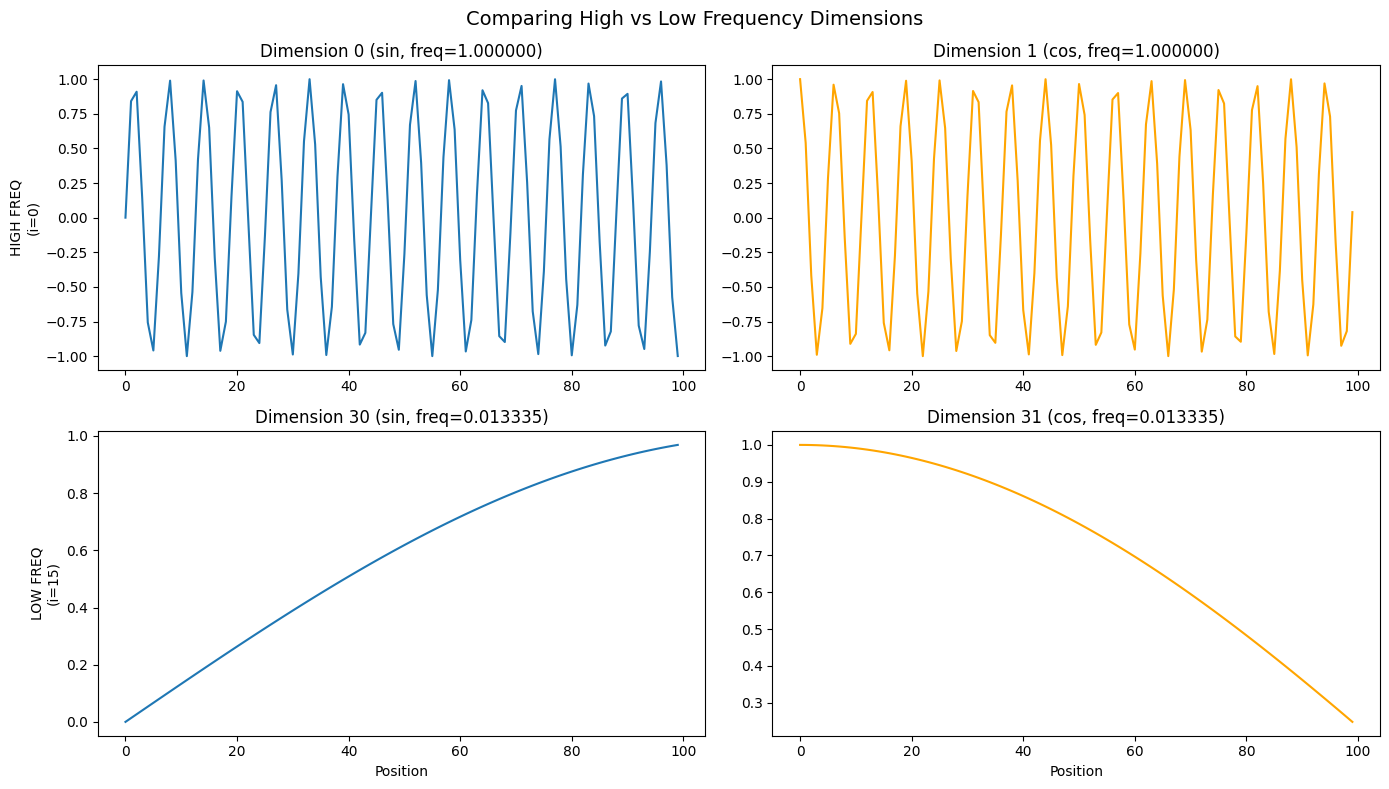

In [311]:
# Look at specific dimensions to see the frequency differences
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

dims_to_show = [(0, 1), (30, 31)]  # high freq pair and low freq pair
pe = pe_vis

for row, (sin_dim, cos_dim) in enumerate(dims_to_show):
    freq_idx = sin_dim // 2
    freq = 1 / (10000 ** (2 * freq_idx / 64))
    
    axes[row, 0].plot(pe[:, sin_dim], linewidth=1.5)
    axes[row, 0].set_title(f'Dimension {sin_dim} (sin, freq={freq:.6f})')
    axes[row, 0].set_ylabel('Encoding value')
    
    axes[row, 1].plot(pe[:, cos_dim], linewidth=1.5, color='orange')
    axes[row, 1].set_title(f'Dimension {cos_dim} (cos, freq={freq:.6f})')

axes[0, 0].set_ylabel('HIGH FREQ\n(i=0)')
axes[1, 0].set_ylabel('LOW FREQ\n(i=15)')
axes[1, 0].set_xlabel('Position')
axes[1, 1].set_xlabel('Position')

plt.suptitle('Comparing High vs Low Frequency Dimensions', fontsize=14)
plt.tight_layout()
plt.show()


In [312]:
# Notice the key property: high freq oscillates rapidly (good for nearby positions)
# while low freq barely changes (but stays unique over long distances)

print("High freq dimension changes quickly between adjacent positions:")
print(f"  pos 0 → 1: {pe[0, 0]:.4f} → {pe[1, 0]:.4f} (Δ = {pe[1, 0] - pe[0, 0]:.4f})")
print(f"  pos 1 → 2: {pe[1, 0]:.4f} → {pe[2, 0]:.4f} (Δ = {pe[2, 0] - pe[1, 0]:.4f})")

print("\nLow freq dimension barely changes:")
print(f"  pos 0 → 1: {pe[0, 30]:.6f} → {pe[1, 30]:.6f} (Δ = {pe[1, 30] - pe[0, 30]:.6f})")
print(f"  pos 1 → 2: {pe[1, 30]:.6f} → {pe[2, 30]:.6f} (Δ = {pe[2, 30] - pe[1, 30]:.6f})")

print("\n→ Together, they give us both local and global position information!")


High freq dimension changes quickly between adjacent positions:
  pos 0 → 1: 0.0000 → 0.8415 (Δ = 0.8415)
  pos 1 → 2: 0.8415 → 0.9093 (Δ = 0.0678)

Low freq dimension barely changes:
  pos 0 → 1: 0.000000 → 0.013335 (Δ = 0.013335)
  pos 1 → 2: 0.013335 → 0.026667 (Δ = 0.013332)

→ Together, they give us both local and global position information!


## Verifying Our Requirements

Let's check that our encoding satisfies what we needed:


In [313]:
# Use a larger encoding for testing
pe_test = positional_encoding(max_len=1000, d_model=64)

# 1. Bounded values - won't explode for long sequences
print("1. BOUNDED VALUES")
print(f"   For 1000 positions: min = {pe_test.min():.4f}, max = {pe_test.max():.4f}")
print(f"   Compare to raw positions: min = 0, max = 999")
print(f"   → Our encoding stays in [-1, 1] regardless of sequence length ✓")


1. BOUNDED VALUES
   For 1000 positions: min = -1.0000, max = 1.0000
   Compare to raw positions: min = 0, max = 999
   → Our encoding stays in [-1, 1] regardless of sequence length ✓


In [314]:
# 2. Unique encodings - every position is distinguishable
print("2. UNIQUE ENCODINGS")

# Check some specific positions we were worried about
pos_0 = pe_test[0]
pos_6 = pe_test[6]   # Remember: with just sin, these were almost identical!
pos_100 = pe_test[100]

print(f"   Distance between pos 0 and pos 6: {np.linalg.norm(pos_0 - pos_6):.4f}")
print(f"   Distance between pos 0 and pos 100: {np.linalg.norm(pos_0 - pos_100):.4f}")
print(f"   → Positions 0 and 6 are now clearly different! ✓")


2. UNIQUE ENCODINGS
   Distance between pos 0 and pos 6: 4.1087
   Distance between pos 0 and pos 100: 5.3151
   → Positions 0 and 6 are now clearly different! ✓


In [315]:
# 3. Smoothness - nearby positions are similar
print("3. SMOOTHNESS")

adjacent_dists = [np.linalg.norm(pe_test[i] - pe_test[i+1]) for i in range(100)]
far_dists = [np.linalg.norm(pe_test[i] - pe_test[i+50]) for i in range(100)]

print(f"   Avg distance between adjacent positions: {np.mean(adjacent_dists):.4f}")
print(f"   Avg distance between positions 50 apart: {np.mean(far_dists):.4f}")
print(f"   → Nearby positions are more similar (smooth) ✓")

# 4. Consistent meaning - position 5 means the same thing regardless of sequence length
print("\n4. CONSISTENT MEANING")
pe_short = positional_encoding(max_len=10, d_model=64)
pe_long = positional_encoding(max_len=10000, d_model=64)

print(f"   Position 5 in length-10 sequence: [{pe_short[5, 0]:.4f}, {pe_short[5, 1]:.4f}, ...]")
print(f"   Position 5 in length-10000 sequence: [{pe_long[5, 0]:.4f}, {pe_long[5, 1]:.4f}, ...]")
print(f"   → Same encoding regardless of sequence length! ✓")


3. SMOOTHNESS
   Avg distance between adjacent positions: 1.4718
   Avg distance between positions 50 apart: 5.7142
   → Nearby positions are more similar (smooth) ✓

4. CONSISTENT MEANING
   Position 5 in length-10 sequence: [-0.9589, 0.2837, ...]
   Position 5 in length-10000 sequence: [-0.9589, 0.2837, ...]
   → Same encoding regardless of sequence length! ✓


## The Mathematical Bonus — Relative Positions

Here's something elegant: attention computes dot products between tokens, including their position encodings. It turns out that `PE(i) · PE(j)` depends mainly on the **relative distance** `|i - j|`, not the absolute positions!

This means the model can potentially learn patterns like "the word 3 positions before" regardless of where in the sequence it occurs.


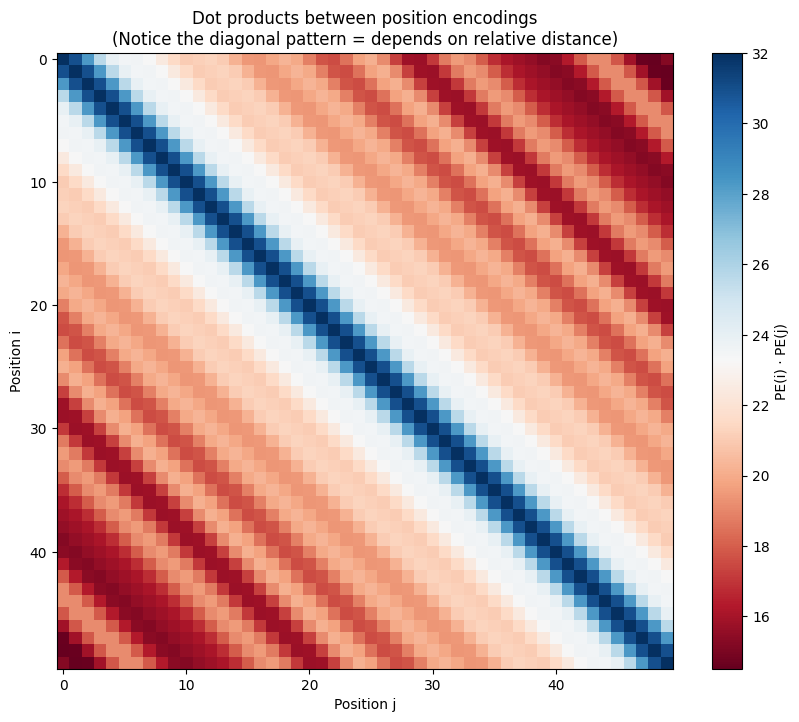

In [316]:
# Let's compute dot products between all position pairs
pe_rel = positional_encoding(50, 64)
dot_products = pe_rel @ pe_rel.T

plt.figure(figsize=(10, 8))
plt.imshow(dot_products, cmap='RdBu')
plt.colorbar(label='PE(i) · PE(j)')
plt.xlabel('Position j')
plt.ylabel('Position i')
plt.title('Dot products between position encodings\n(Notice the diagonal pattern = depends on relative distance)')
plt.show()


In [319]:
# The dot product depends mainly on the DIFFERENCE between positions
# PE(5) · PE(8) ≈ PE(10) · PE(13) because both have distance 3

print("Dot products for pairs with same relative distance:\n")
print("Positions      | Distance | Dot Product")
print("-" * 45)

for offset in [0, 3, 20]:
    pairs = [(0, 0+offset), (10, 10+offset), (25, 25+offset)]
    dots = [np.dot(pe_rel[i], pe_rel[j]) for i, j in pairs]
    print(f"(0,{offset}), (10,{10+offset}), (25,{25+offset}) |    {offset}     | {dots[0]:.2f}, {dots[1]:.2f}, {dots[2]:.2f}")
    
print("\n→ Same relative distance = similar dot products!")


Dot products for pairs with same relative distance:

Positions      | Distance | Dot Product
---------------------------------------------
(0,0), (10,10), (25,25) |    0     | 32.00, 32.00, 32.00
(0,3), (10,13), (25,28) |    3     | 25.59, 25.59, 25.59
(0,20), (10,30), (25,45) |    20     | 18.88, 18.88, 18.88

→ Same relative distance = similar dot products!


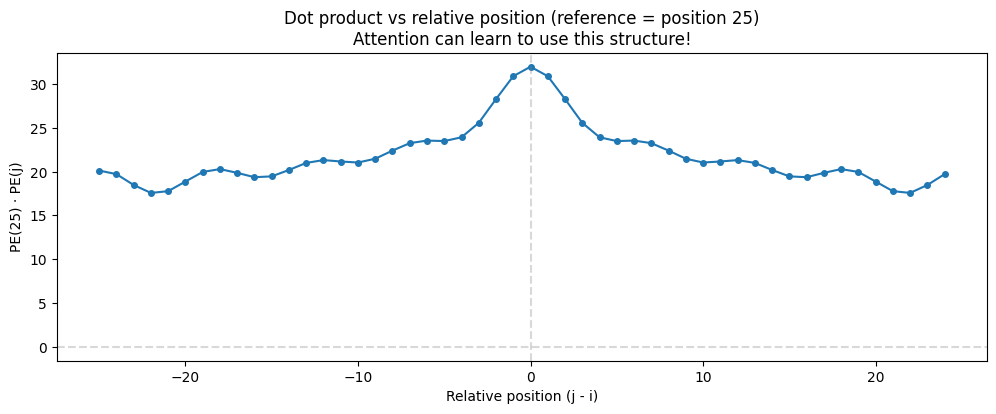

→ The dot product decays smoothly with distance
→ This gives the model a signal about relative position!


In [321]:
# How does dot product vary with relative distance?
# Pick a reference position and compute dot product with all other positions

# Use pe_rel from earlier (50 positions) OR create it here
pe_rel = positional_encoding(50, 64)

reference_pos = 25
dot_vs_distance = pe_rel[reference_pos] @ pe_rel.T  # using pe_rel, not pe

plt.figure(figsize=(12, 4))
plt.plot(np.arange(50) - reference_pos, dot_vs_distance, 'o-', markersize=4)
plt.xlabel('Relative position (j - i)')
plt.ylabel('PE(25) · PE(j)')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.title(f'Dot product vs relative position (reference = position {reference_pos})\nAttention can learn to use this structure!')
plt.show()

print("→ The dot product decays smoothly with distance")
print("→ This gives the model a signal about relative position!")

## Summary: The Formula Demystified

Now the original formula should make sense:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

| Component | What it does |
|-----------|--------------|
| `pos` | The position in the sequence (0, 1, 2, ...) |
| `i` | Which dimension pair we're computing (0 to d/2-1) |
| `d` | Total embedding dimension |
| `10000^(2i/d)` | Scales frequency: i=0 gives high freq, i=d/2 gives low freq |
| `sin` / `cos` | Orthogonal signals at each frequency |
| Alternating | Even dims get sin, odd dims get cos |

**Why this works:**
- Multiple frequencies → unique encoding per position
- High frequencies → distinguish nearby positions  
- Low frequencies → avoid repetition over long contexts
- Sin + cos → orthogonal, complete representation of rotation
- Linear transformation → can extract relative positions


## Looking Ahead: Limitations and RoPE

This sinusoidal encoding has served well, but has limitations:

1. **Position info gets "mixed in"** — we add PE to token embeddings, so the model has to disentangle them
2. **Relative position is implicit** — the model *can* learn it through the dot product, but doesn't have to
3. **The encoding is fixed** — not learned for the specific task

**RoPE (Rotary Position Embedding)** addresses these by:
- Applying position as a **rotation** to the query/key vectors instead of adding
- Making relative position **explicit** in the attention computation  
- Preserving the same intuitions: multiple frequencies, sin/cos pairs as rotation

The key insight: instead of `q + PE(pos)`, RoPE does `rotate(q, pos)`. We'll explore this next!


In [322]:
import torch

def sinusoidal_positional_encoding(max_len: int, d_model: int) -> torch.Tensor:
    """
    Generate sinusoidal positional encodings as in "Attention Is All You Need".
    
    Args:
        max_len: Maximum sequence length
        d_model: Embedding dimension (must be even)
        
    Returns:
        Tensor of shape (max_len, d_model)
    """
    position = torch.arange(max_len).unsqueeze(1)  # (max_len, 1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model)
    )  # (d_model/2,)
    
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

# Test it
pe_torch = sinusoidal_positional_encoding(100, 64)
print(f"Shape: {pe_torch.shape}")
print(f"Values in range [{pe_torch.min():.2f}, {pe_torch.max():.2f}]")

Shape: torch.Size([100, 64])
Values in range [-1.00, 1.00]
